$$\newcommand{\worth}{v}
\newcommand{\gammaCdf}[3]{\mathcal{GAMMA CDF}\left(#1|#2,#3\right)}
\newcommand{\gammaDist}[3]{\mathcal{G}\left(#1|#2,#3\right)}
\newcommand{\gammaSamp}[2]{\mathcal{G}\left(#1,#2\right)}
\newcommand{\cdf}{\text{cdf}}
$$

# Relative Improvement Decision Making
   
### 2018-06-07

### Neil D. Lawrence

The idea of relative improvement is that our personal utility is related to our relative change in society. For example, our sensitivity to an increase in salary is dependent on how it situates us relative to our peers, rather than an absolute change in position.
   
How a change in circumstance effects us, is therefore related to our context, and how resources or income are distributed throughout our community.

Firstly, we'll consider a worked example. 

### Marginal Utility

As a starting example, consider the *logarithmic utility* as suggested by Daniel Bernoulli. If we are sensitive to the log of change, we can inverse engineer what our *assumption* about the underlying distribution of resources or income is.

Expected gain under logarithmic utility is 
$$
\log \worth_2 - \log \worth_1
$$
If we are interested in our relative position in the population, this implies our change in relative position is given by
$$
\cdf(\worth_2) - \cdf(\worth_1)
$$
which implies that we are assuming that the logarithm is the cumulative distribution function (CDF) of the underlying wealth distribution. To recover the probability density function (PDF) we differentiate the CDF and recover,
$$
p(\worth) = \frac{1}{\worth}
$$
which is not a correctly normalized distribution, but is often used as an improper density covering the positive half space, i.e. if we don't have knowledge of the underlying density then defining the Gamma density as,
$$
\gammaDist{\worth}{a}{b} = \frac{b^a \worth^{a-1}e^{-b\worth}}{\Gamma(a)}
$$
we can take the limit as $a\rightarrow 0$ and $b\rightarrow 0$ and recover the improper prior over $\worth$ of $\frac{1}{\worth}$ as suggested by Daniel Bernoulli's logarithmic utility.

Given our starting example, which reverse engineered an existing marginal utility, we can now start from a more usual assumption of the distribution of resource or income, the Pareto distribution, and engineer directly a utility based on the idea of *relative improvement*. 

The Pareto distribution is a density proposed to model the wealth or income in a population. 
$$
p(\worth) = \frac{\alpha \worth_m^\alpha}{\worth^{\alpha+1}}
$$
The CDF for the Pareto density is given by
$$
\cdf(\worth) = 1 - \left(\frac{\worth_m}{\worth}\right)^\alpha
$$
So the marginal utility is given by
$$
m(\worth_1, \worth_2) = \left(\frac{\worth_m}{\worth_1}\right)^\alpha-\left(\frac{\worth_m}{\worth_2}\right)^\alpha
$$




$$
m(\worth_1, \worth_2) = \left(\frac{\worth_m}{\worth_1}\right)^\alpha-\left(\frac{\worth_m}{\worth_2}\right)^\alpha
$$
$$
m(\worth_1, \worth_2) = \worth_m^\alpha\frac{\worth_2^\alpha - \worth_1^\alpha}{\left(\worth_1\worth_2\right)^\alpha}
$$
$$
m(\worth_1, \worth_2) = \left(\frac{\worth_m}{\worth_1}\right)^\alpha\frac{\worth_2^\alpha - \worth_1^\alpha}{\worth_2^\alpha}
$$
$$
m(\worth_1, \worth_2) = \left(\frac{\worth_m}{\worth_1}\right)^\alpha\frac{(\worth_1 + \delta\worth)^\alpha - \worth_1^\alpha}{(\worth_1+\delta\worth)^\alpha}
$$

For the most exterme case $\alpha=1$ we have
$$
m(\worth_1, \worth_2) = \worth_m\frac{\worth_2 - \worth_1}{\worth_1\worth_2}
$$
considering $\delta \worth$
$$
m(\delta\worth) = \frac{\worth_m}{\worth_1}\frac{\delta \worth}{(\delta\worth + \worth_1)}
$$

In [6]:
from scipy.special import gammainc, gamma

In [23]:
class Utility():
    def __init__(self):
        pass
    
    def u(self, c):
        """Utility function"""
        raise NotImplementedError
        
    def uprime(self, c):
        raise NotImplementedError

    def v(self, cstar, deltac):
        """Value function"""
        return self.u(cstar+deltac) - self.u(cstar)    
        
    def A(self, c):
        """Absolute risk aversion"""
        raise NotImplementedError
        
    def R(self, c):
        """Relative risk aversion"""
        return self.ara*c
    
    def G(self):
        """Gini coefficient"""
        raise NotImplementedError

    def _repr_html_(self):
        raise NotImplementedError
        
class Exponential(Utility):
    def __init__(self, a=1.):
        Utility.__init__(self)
        self.a = 1.
        
    def u(self, c):
        return 1-np.exp(-self.a*c)
    
    def uprime(self, c):
        return self.a*np.exp(-self.a*c)
    
    def A(self, c):
        return self.a*np.ones(c.shape)
    
    def R(self, c):
        """Relative risk aversion"""
        return self.a/c
    
    def G(self):
        """Gini coefficient"""
        return 0.5
    
class Log(Utility):
    def __init__(self, a=1., b=0.):
        """Log utility function. This utility funciton doesn't have an associated underlying PDF, but 1/c is often used as an uninformative prior across a space"""
        Utility.__init__(self)
        self.a = a
        self.b = b
        
    def u(self, c):
        return np.log(self.a*c + self.b)
    
    def uprime(self, c):
        return 1./(self.a*c + self.b)
    
    def A(self, c):
        """Absolute risk aversion"""
        return 1./(self.a*c + self.b)
    
    def R(self, c):
        """Relative risk aversion"""
        if self.b == 0:
            return np.ones(c.shape)/self.a
        else:
            return c/(self.a*c + self.b) 

class Linear(Utility):
    def __init__(self, a=1., b=0.):
        Utility.__init__(self)
        self.a=a
        self.b=b
    
    def u(self, c):
        return self.a*c + self.b
    
        
class Isoelastic(Utility):
    def __init__(self, eta):
        Utility.__init__(self)
        self.eta=eta
        
    def u(self, c):
        if self.eta==1:
            return np.log(c)
        else:
            return (c**(1-self.eta) - 1)/(1-self.eta)
        
    def uprime(self, c):
        if self.eta==1:
            return c**(1-2*self.eta)
        
    def A(self, c):
        """Absolute risk aversion"""
        return (2.*self.eta - 1.)/c
    
    def R(self, c):
        """Relative risk aversion"""
        return (2.*self.eta - 1)
    
    
class LogLogistic(Utility):
    def __init(self, alpha=1., beta=1.):
        Utility.__init__(self)
        self.alpha = alpha
        self.beta = beta
        
    def u(self, c):
        return 1/(1+(c/self.alpha)**-self.beta)
    
    def uprime(self, c):
        return ((self.beta/self.alpha)*(c/self.alpha)**(self.beta-1))/(1+(c/self.alpha)**self.beta)**2
    
    def A(self, c):
        """Absolute risk aversion"""
        return (self.beta-1.)/c - 2/(self.alpha + c)
    
    def R(self, c):
        """Relative risk aversion"""
        return self.beta -1. - 2/(self.alpha/c + 1.)
    
    def G(self):
        """Gini coefficient"""
        return 1./self.beta

class Pareto(Utility):
    def __init__(self, c_m=0., alpha=1.):
        Utility.__init__()
        self.c_m = c_m
        self.alpha = alpha

    def _lims(self, c):
        return np.where(c<self.c_m), np.where(c>=self.c_m), np.zeros(c.shape)

    def u(self, c):
        ind1, ind2, ret = self._lims(c)
        ret[ind2] = 1-(self.c_m/c)**self.alpha
        ret[ind1] = 0
        return ret
    
    def uprime(self, c):
        ind1, ind2, ret = self._lims(c)
        ret[ind2] = self.alpha*self.c_m**self.alpha/c**(self.alpha+1)
        ret[ind1] = 0
        return ret
    
    def A(self, c):
        """Absolute risk aversion"""
        ind1, ind2, ret = self._lims(c)
        ret[ind2] = (self.alpha + 1.)/self.c
        ret[ind1] = np.NaN
        
    def R(self, c):
        """Relative risk aversion"""
        ind1, ind2, ret = self._lims(c)
        ret[ind2] = self.alpha + 1.
        ret[ind1] = np.NaN
        
    def G(self):
        """Gini coefficient"""
        if self.alpha > 1.:
            return 1/(2*self.alpha-1)
        elif self.alpha > 0:
            return 1.
        
class Gamma(Utility):
    def __init__(self, c, a=1., b=1.):
        Utility.__init__()
        self.a = a
        self.b = b
        
    def u(self, c):
        """Utility"""
        sp.special.gammainc(self.a, self.b*c)/sp.special.gamma(self.a)
        
    def uprime(self, c):
        """pdf"""
        return self.b**self.a/sp.special.gamma(self.a)*c**(self.a-1)*np.exp(-self.b*c)
        
    def A(self, c):
        """Absolute risk aversion"""
        return (self.a-1)/c - self.b
    
    def R(self, c):
        """Relative risk aversion"""
        return (self.a-1) - self.b*c
        
    def G(self):
        """Gini coefficient"""
        return sp.special.gamma((2*a+1)/2)/(a*sp.special.gamma(a)*np.sqrt(np.pi))
    
class LogNormal(Utility):
    def __init__(self, mu=1., sigma=1.):
        Utility.__init__()
        self.mu = mu
        self.sigma = sigma
        self.sigma2 = sigma*sigma
        
    def u(self, c):
        """Utility"""
        return 0.5 + 0.5*sp.special.erf((np.log(c)-self.mu)/(np.sqrt(2)*self.sigma))
        
    def uprime(self, c):
        """pdf"""
        return 1./(c*self.sigma*np.sqrt(2*np.pi))*np.exp(-((np.log(c)-self.mu)**2)/(2*self.sigma2))
        
    def A(self, c):
        """Absolute risk aversion"""
        return 1./c*(1+ (np.log(c)-self.mu)/(2*self.sigma2))
        
    def R(self, c):
        """Relative risk aversion"""
        return (1+ (np.log(c)-self.mu)/(2*self.sigma2))
    def G(self):
        """Gini coefficient"""
        return sp.special.erf(self.sigma/2)
    
class LogCauchy(Utility):
    def __init__(self, mu=1., sigma=1.):
        Utility.__init__()
        self.mu = mu
        self.sigma = sigma
        self.sigma2 = sigma*sigma
        
    def u(self, c):
        """Utility"""
        return 1./np.pi *np.atan((np.log(c)-self.mu)/self.sigma)
    
    def uprime(self, c):
        """pdf"""
        return 1./(c*np.pi)*(self.sigma/((np.log(c)-self.mu)**2 + self.sigma2))
        
    def A(self, c):
        """Absolute risk aversion"""
        return 1./c + 2./c*(np.log(c)-self.mu)/((np.log(c)-self.mu)**2 + self.sigma2)
        
    def R(self, c):
        """Relative risk aversion"""
        return 1 + 2.*(np.log(c)-self.mu)/((np.log(c)-self.mu)**2 + self.sigma2)

    
class Weibull(Utility):
    def __init__(self, k=1., lambd=1.):
        Utility.__init__()
        self.k = k
        self.lambd = lambd
        
    def u(self, c):
        """Utility"""
        return 1-np.exp(-(self.lambd*c)**self.k)
        
    def uprime(self, c):
        """pdf"""
        return self.k/self.lambd*(c/self.lambd)**(self.k-1)*np.exp(-(c/self.lambd)**self.k)
        
    def A(self, c):
        """Absolute risk aversion"""
        return -(self.k-1)/c + (self.k-1)*(c/self.lambd)**(self.k-1)
        
    def R(self, c):
        """Relative risk aversion"""
        return -(self.k-1) + c*(self.k-1)*(c/self.lambd)**(self.k-1)
    
    def G(self):
        """Gini coefficient"""
        return 1-2**(-1/self.k)

In [42]:
c = np.random.randn(10, 1)
np.ones(c.shape)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10, 7))
vm = 1
v1 = 4000
alpha = 20
a=9
b=0.0003
dv = np.linspace(-4000, 5000, 100)

In [ ]:
# From CDF of Pareto density
m = Pareto(c_m = 1, alpha=20).v(v1, dv)
m = np.exp(alpha*np.log(vm/v1) - alpha*np.log(dv+v1))*((v1+dv)**alpha-v1**alpha)

In [ ]:
# From CDF of 1/x
m = Logarithmic().v(v1, dv)
m2 = np.log(v1+dv)-np.log(v1)

In [ ]:
# From CDF of Gamma density
m3 = Gamma(a=a, b=b).v(v1, dv)
m3 = (gammainc(a, b*(v1+dv))-gammainc(a, b*v1))/gamma(a)

/Users/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


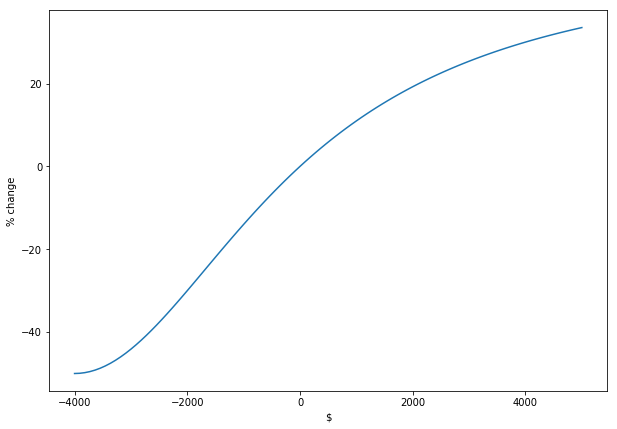

In [41]:
# Log Logistic (Dagum idstribution)
alpha = 4000
beta = 2
p = 1
m4 = LogLogistic(alpha=alpha, beta=beta, p=p).v(v1, dv)
m4 = (1+(alpha/(v1+dv))**beta)**-p - (1+(alpha/v1)**beta)**-p

plt.ylabel('% change')
plt.xlabel('$')
#ax.plot(dv, m*100)
_ = ax.plot(dv, m4*100)

### Connections with Prospect Theory

From reading [Prospect Theory](https://www.jstor.org/stable/1914185) [@Kahneman:prospect79], the main contribution seems to be the non-concavity of the value function (utility function). This arises in Relative Improvement when the probability density has a non zero mode. 

The study adds further experimental evidence that people who "have" make more risk-averse decisions, while the "have-nots" make more risk-seeking decisions. This phenomenon has frequently been observed from studies using hypothetical decision-making situations [@Thaler:gambling90] and agrees with the increased risk aversion principle of Prospect Theory. This theory predicts exactly what we found, that is, prior losses put the subject in the domain of losses and prior gains have the opposite effect. http://journal.sjdm.org/06137/jdm06137.htm

 An essential feature of the present theory is that the carriers of value are
 changes in wealth or welfare, rather than final states. This assumption is compati-
 ble with basic principles of perception and judgment. Our perceptual apparatus is
 attuned to the evaluation of changes or differences rather than to the evaluation of
 absolute magnitudes. When we respond to attributes such as brightness, loudness,
 or temperature, the past and present context of experience defines an adaptation
 level, or reference point, and stimuli are perceived in relation to this reference
 point [23]. Thus, an object at a given temperature may be experienced as hot or
 cold to the touch depending on the temperature to which one has adapted. The
 same principle applies to non-sensory attributes such as health, prestige, and
 wealth. The same level of wealth, for example, may imply abject poverty for one
 person and great riches for another-depending on their current assets.
 
  Many elements of the evaluation model have appeared in previous attempts to
 modify expected utility theory. Markowitz [29] was the first to propose that utility
 be defined on gains and losses rather than on final asset positions, an assumption
 which has been implicitly accepted in most experimental measurements of utility
 (see, e.g., [7, 32]). Markowitz also noted the presence of risk seeking in pref-
 erences among positive as well as among negative prospects, and he proposed a
 utility function which has convex and concave regions in both the positive and the
 negative domains. His treatment, however, retains the expectation principle;
 hence it cannot account for the many violations of this principle; see, e.g., Table I.
 The replacement of probabilities by more general weights was proposed by
 Edwards [9], and this model was investigated in several empirical studies (e.g.,  [3, 42]). Similar models were developed by Fellner [12], who introduced the concept of decision weight to explain aversion for ambiguity, and by van Dam [46]
 who attempted to scale decision weights. For other critical analyses of expected
 utility theory and alternative choice models, see Allais [2], Coombs [6], Fishburn
 [13], and Hansson [22].
 
  The equations of prospect theory retain the general bilinear form that underlies
 expected utility theory. However, in order to accomodate the effects described in
 the first part of the paper, we are compelled to assume that values are attached to
 changes rather than to final states, and that decision weights do not coincide with
 stated probabilities. These departures from expected utility theory must lead to
 normatively unacceptable consequences, such as inconsistencies, intransitivities,
 and violations of dominance. Such anomalies of preference are normally cor-
 rected by the decision maker when he realizes that his preferences are inconsis-
 tent, intransitive, or inadmissible. In many situations, however, the decision
 maker does not have the opportunity to discover that his preferences could violate
 decision rules that he wishes to obey. In these circumstances the anomalies
 implied by prospect theory are expected to occur.

https://core.ac.uk/download/pdf/7048428.pdf

[@Ramsey:truth26]

The Use of Distribution Functions to Represent Utility Functions
https://www.jstor.org/stable/2629422?seq=1#page_scan_tab_contents [@Berhold:distribution73]

Concavity of utility leads to decreasing marginal returns. 

von-Neumann-Morgenstern utility functions (VNM-utility functions) 

[@vonNeumann:games44]

In [75]:
import numpy as np

In [77]:
len(prospects)

1

In [81]:
p_vec

array([[0.89],
       [0.1 ]])

In [113]:
utility = Linear()
prospects = [(1e6, 0.89), (5e6, 0.11)]
#prospects = [(1e6, 1)]
prospects= [(5e6, 0.10)]
denom = 0.
p_vec = np.zeros((len(prospects), 1))
c_vec = np.zeros((len(prospects), 1))
for i, (c, p) in enumerate(prospects):
    p_vec[i] = p
    c_vec[i] = c
    
u_vec = utility.u(c_vec)
expec = p_vec.T@u_vec
sd = np.sqrt(u_vec.T@(np.diag(p_vec.flatten())-p_vec@p_vec.T)@u_vec)
print(expec - 0.5*sd)

[[-250000.]]


In [106]:
print(expec+sd)

[[422889.75694324]]


In [103]:
expec

array([[1440000.]])

In [25]:
utility = Linear()
prospects = [(1e6, 0.89), (5e6, 0.1)]
prospects = [(1e6, 1)]

denom = 0.
for v, p in prospects:
    denom += utility.u(v)*p
    
lnexpec = 0.
for v, p in prospects:
    num = utility.u(v)*p
    print(num/denom)
    lnexpec += num/denom*np.log(utility.u(v))

expec = np.exp(lnexpec)

print(expec)

1.0
999999.9999999995


In [17]:
np.log(5e6)

15.424948470398375

In [53]:
p = np.random.rand(10, 1)
p /= p.sum()

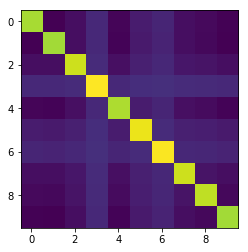

In [54]:
import matplotlib.pyplot as plt
plt.imshow(np.eye(10)-np.sqrt(p)@np.sqrt(p).T)

In [55]:
U, V = np.linalg.eig(np.eye(10) - np.sqrt(p)@np.sqrt(p).T)

In [56]:
np.sqrt(p).T@np.sqrt(p)

array([[1.]])

In [73]:
V[:, 1]/np.sqrt(p).T

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

In [40]:
plt.

array([ 1.        +0.00000000e+00j, -3.72629585+0.00000000e+00j,
        1.        +1.01029669e-16j,  1.        -1.01029669e-16j,
        1.        +0.00000000e+00j,  1.        +0.00000000e+00j,
        1.        +0.00000000e+00j,  1.        +0.00000000e+00j,
        1.        +0.00000000e+00j,  1.        +0.00000000e+00j])